In [1]:
import numpy as np
import pandas as pd

dn = '/Users/aa/lab/kaggle/couponpurchase/data/'
users = pd.read_csv(dn+'common/user_list.csv', parse_dates=['REG_DATE', 'WITHDRAW_DATE'])
users.set_index('USER_ID_hash', inplace=True)

kens = pd.read_csv(dn+'common/prefecture_locations.csv', 
                         header=0, encoding='utf-8-sig')

def read_cpn_data(file):
    cpn = pd.read_csv(dn+file, parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND'])
    cpn = cpn[['COUPON_ID_hash', 'CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE',
              'large_area_name', 'ken_name', 'small_area_name']]
    cpn = pd.merge(cpn, kens, left_on=['ken_name'], right_on=['PREF_NAME'])
    cpn.drop(['PREFECTUAL_OFFICE', 'PREF_NAME'], inplace=True, axis=1)
    cpn.set_index('COUPON_ID_hash', inplace=True)
    cpn[['PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE']] = cpn[['PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE']].astype(float)
    cpn[['DISCOUNT_PRICE']] = cpn[['DISCOUNT_PRICE']] + 0.01
    cpn[['CATALOG_PRICE', 'DISCOUNT_PRICE']] = cpn[['CATALOG_PRICE', 'DISCOUNT_PRICE']].apply(np.log10)
    return cpn

cpn = read_cpn_data('train/coupon_list_train.csv')
cpn_test = read_cpn_data('test/coupon_list_test.csv')
prch = pd.read_csv(dn+'train/coupon_detail_train.csv', parse_dates=['I_DATE'])
view = pd.read_csv(dn+'train/coupon_visit_train.csv', parse_dates=['I_DATE'])

atrain = pd.read_csv(dn+'train/coupon_area_train.csv')
atest = pd.read_csv(dn+'test/coupon_area_test.csv')

### Choose real data or validation data

In [2]:
USE_REAL_DATA = True

if USE_REAL_DATA:
    past_cpn = cpn
    fut_cpn = cpn_test
    prch_before = prch
    view_before = view
    a_past = atrain
    a_fut = atest
else:
    # For local validation
    cutoff_date = '2012-06-17'
    cpnid_prch_before = prch[prch.I_DATE<cutoff_date].COUPON_ID_hash.unique()
    cpnid_prch_after_mixed = prch[prch.I_DATE>=cutoff_date].COUPON_ID_hash.unique()
    cpnid_view_before = view[view.I_DATE<cutoff_date].VIEW_COUPON_ID_hash.unique()
    
    print('Raw: PrchBefore = {}, PrchAfterMixed = {}, ViewBefore = {}'.format(
            len(set(cpnid_prch_before)), len(set(cpnid_prch_after_mixed)),
            len(set(cpnid_view_before))))

    # fut_cpn should not include cpns that were either purchased or viewed before
    cpnid_prch_after_clean = set(cpnid_prch_after_mixed) - set(cpnid_prch_before) - set(cpnid_view_before)

    prch_before = prch[prch.I_DATE<cutoff_date]
    view_before = view[view.I_DATE<cutoff_date]

    past_cpn = cpn[cpn.index.isin(cpnid_prch_before)]
    fut_cpn = cpn[cpn.index.isin(cpnid_prch_after_clean)]
    
    a_past = atrain[atrain.COUPON_ID_hash.isin(cpnid_prch_before)]
    a_fut = atrain[atrain.COUPON_ID_hash.isin(cpnid_prch_after_clean)]
    
    print('Processed: past_cpn = {}, fut_cpn = {}'.format(len(past_cpn), len(fut_cpn)))

### Encode categorical features

In [3]:
from sklearn.feature_extraction import DictVectorizer

def encode_categorical(dftrain, dftest, cols, sep='_'):
    vec = DictVectorizer(separator=sep)
    v_dftrain = pd.DataFrame(vec.fit_transform(dftrain[cols].to_dict(orient='records')).toarray())
    v_dftest = pd.DataFrame(vec.transform(dftest[cols].to_dict(orient='records')).toarray())
    
    v_dftrain.columns = vec.get_feature_names()
    v_dftest.columns = vec.get_feature_names()
    
    v_dftrain.index = dftrain.index
    v_dftest.index = dftest.index

    dftrain = dftrain.drop(cols, axis=1)
    dftrain = dftrain.join(v_dftrain)

    dftest = dftest.drop(cols, axis=1)
    dftest = dftest.join(v_dftest)
    
    return dftrain, dftest

def test_encode_categorical():
    np.random.seed(42)
    df1 = pd.DataFrame(np.random.randn(5, 1), columns=['a'])
    df1['b'] = [np.random.choice(('CA', 'NJ', 'NY')) for i in range(df1.shape[0])]
    df1['c'] = [np.random.choice(('Chrome', 'Firefox')) for i in range(df1.shape[0])]

    df2 = pd.DataFrame(np.random.randn(3, 1), columns=['a'])
    df2['b'] = [np.random.choice(('CA', 'NJ', 'NY', 'WA')) for i in range(df2.shape[0])]
    df2['c'] = [np.random.choice(('Chrome', 'Firefox', 'Safari')) for i in range(df2.shape[0])]


    # Vectorize the categorical columns: e & f
    cols=['b', 'c']

    print(df1)
    print(df2)

    df1, df2 = encode_categorical(df1, df2, cols)

    print(df1)
    print(df2)

In [4]:
a_past, a_fut = encode_categorical(a_past, a_fut, ['PREF_NAME', 'SMALL_AREA_NAME'], sep='-ar-')
a_past.set_index('COUPON_ID_hash', inplace=True)
a_fut.set_index('COUPON_ID_hash', inplace=True)
a_past = a_past.groupby(a_past.index).sum()
a_fut = a_fut.groupby(a_fut.index).sum()
a_past = a_past*0.35
a_fut = a_fut*0.35
past_cpn = pd.merge(past_cpn, a_past, how='left', left_index=True, right_index=True)
fut_cpn = pd.merge(fut_cpn, a_fut, how='left', left_index=True, right_index=True)

In [5]:
p1, f1 = encode_categorical(past_cpn, fut_cpn, ['CAPSULE_TEXT', 'GENRE_NAME',
                                                'large_area_name', 'ken_name', 
                                                'small_area_name'])

### Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
def scale_cpn_attrs(cpn_train, cpn_test):
    attrs = ['PRICE_RATE','CATALOG_PRICE', 'DISCOUNT_PRICE', 'LATITUDE', 'LONGITUDE']
    max_values = {'PRICE_RATE':1, 'CATALOG_PRICE':1, 'DISCOUNT_PRICE':1,
                  'LATITUDE':13, 'LONGITUDE':13}
    for a in attrs:
        scaler = MinMaxScaler(feature_range=(0,max_values[a]))
        cpn_train[[a]] = scaler.fit_transform(cpn_train[[a]])
        cpn_test[[a]] = scaler.transform(cpn_test[[a]])
    return cpn_train, cpn_test

p1, f1 = scale_cpn_attrs(p1, f1)

In [8]:
#           PriceRate  P1    P2   Lat  Lon T1 T2
#c1 = np.array([.5,    3.00, 2.69, 0.8, 2.0, 0, 0])
#c2 = np.array([.6,    3.30, 3.07, 0.6, 1.2, 0, 0])
#c3 = np.array([.1,    4.00, 3.90, 2.6, 3.0, 1, 1])
#dist_fn = lambda ca,cb: (1/(1+np.sqrt((np.sum(np.power(ca - cb, 2))))))
#print(dist_fn(c1, c2), dist_fn(c1, c3), dist_fn(c2, c3))

## Compute sim_matrix

In [9]:
def new_sim_distance(p1, f1, idx):
    return (1/(1+np.sqrt((np.sum(np.power(f1 - p1.loc[idx], 2), axis=1)))))

sim_matrix = {}
for i, idx in enumerate(p1.index):
    if (i%1000 == 0):
        print(i)
    sim_matrix[idx] = new_sim_distance(p1, f1, idx)
print(len(sim_matrix))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
19413


## Compute most similar items for each user

1.0 0.983313246982 0.935110344111 0.860991896331 0.554313266133 0.108626532265 0.0548279573604


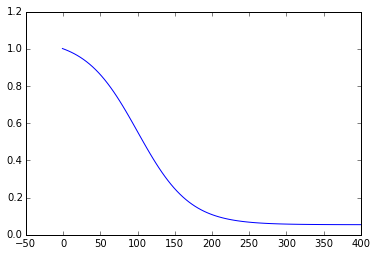

In [10]:
from matplotlib import pyplot as plt
from scipy.special import expit
%matplotlib inline

x = np.linspace(-1,400,100)
scale_fn = lambda x: 1.0543132661328272 - (1 / (1 + np.exp(-(x-100)/35)))
y = scale_fn(x)
plt.plot(x, y)
print(scale_fn(0), scale_fn(10), scale_fn(30), scale_fn(50), 
      scale_fn(100), scale_fn(200), scale_fn(365))

# for dampening the effect of views way in the past
scaling_factor = {}
for x in range(-1,500):
    scaling_factor[x] = scale_fn(x)

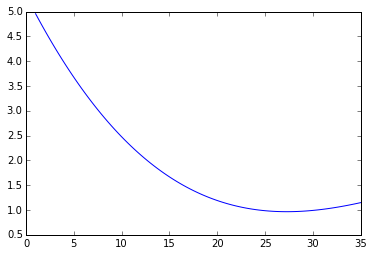

In [11]:
# for strengthening the effect of recent views
# Orig: recent_views_weight_fn = lambda x: 5.3271 - 3.7962e-01*x + 1.0245e-02*x**2 - 8.0264e-05*x**3
recent_views_weight_fn = lambda x: 5.3271 - 3.7962e-01*x + 1.0245e-02*x**2 - 8.0264e-05*x**3
#recent_views_weight_fn = lambda x: 1

x = np.linspace(1, 35, 100)
plt.plot(x, recent_views_weight_fn(x))

recent_views_weight = {}
for x in range(-1,35):
    recent_views_weight[x] = recent_views_weight_fn(x)

In [12]:
from collections import defaultdict
topn = 10

prch_dict = defaultdict(list)
for arr in prch_before.values:
    prch_dict[arr[4]].append(arr[5])
    
max_view_date = view_before.I_DATE.max()
view_dict = defaultdict(list)
for arr in view_before.values:
    days_since_view = (max_view_date-arr[1]).days
    view_dict[arr[5]].append((arr[4], days_since_view))

sim_matrix_topn = {}
for k in sim_matrix:
    sim = sim_matrix[k]
    sim_topn = sim.nlargest(n=topn)
    sim_matrix_topn[k] = sim_topn

In [13]:
import csv
import heapq

pred = []

for i, ui in enumerate(users.index):
    if (i%1000 == 0):
        print(i)
    pred_usr = defaultdict(float)
    
    usr_prch = prch_dict[ui]
    for cpn_id in usr_prch:
        sim_topn = sim_matrix_topn[cpn_id]
        for topper in sim_topn.iteritems():
            pred_usr[topper[0]] += topper[1]
            
    usr_view = view_dict[ui]
    for cpn_id, cpn_days in usr_view:
        if cpn_id in sim_matrix_topn:
            sim_topn = sim_matrix_topn[cpn_id]
            for topper in sim_topn.iteritems():
                if cpn_days <= 30:
                    pred_usr[topper[0]] += (topper[1] * recent_views_weight[cpn_days])
                else:
                    pred_usr[topper[0]] += (topper[1] * 0.1 * scaling_factor[cpn_days])
                
            
    topn_for_usr = heapq.nlargest(topn, pred_usr, key=pred_usr.get)
    pred.append([ui, ' '.join(topn_for_usr)])

with open('s-output-017.csv', 'w') as f:
    a = csv.writer(f)
    a.writerow(['USER_ID_hash', 'PURCHASED_COUPONS'])
    a.writerows(pred)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [14]:
#from scoring import read_csv_purchases as rcsv, mapk
#print(mapk(rcsv('actual-010.csv'), rcsv('output-014.csv')))